In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
#nltk.download('vader_lexicon')
import spacy
import re

from wordcloud import WordCloud 
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from langdetect import detect
from langdetect import DetectorFactory
from sklearn.model_selection import train_test_split


In [2]:
data_train = pd.read_excel(r'C:\TextMining\Data_Project\train.xlsx')
data_reviews = pd.read_excel(r'C:\TextMining\Data_Project\train_reviews.xlsx')

In [3]:
data_train

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0
...,...,...,...,...
6243,6244,"Studio 15 is a new, very well decorated and co...",I'm a Brand Manager from Lisbon in Portugal bu...,0
6244,6245,Lisbon meets a cosmopolitan industrial one-bed...,Home is where feelings are visitors. How do we...,0
6245,6246,<b>License number</b><br />Exempt,I am a travel agent passionate by cultures. \n...,1
6246,6247,Campo Pequeno Prestige is a classy and top qua...,Família_x000D_\nPortugal_x000D_\nGavião_x000D_...,0


In [4]:
data_reviews

,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."
3,1,Das Hostel war neu und deshalb funktionierte a...
4,1,"It was fine for a dorm, but I think for the pe..."
...,...,...
361276,6248,The location was perfect. The apartment was ve...
361277,6248,Ana's place is exactly as described and even b...
361278,6248,A Ana foi muito atenciosa e preocupou se com o...
361279,6248,No wifi nor answer. <br/>The wifi can’t be con...


In [5]:
data_reviews['comments'] = data_reviews['comments'].astype(str)

In [6]:
aggregated_reviews = data_reviews.groupby('index')['comments'].agg(' '.join).reset_index()

In [7]:
aggregated_reviews

,index,comments
0,1,this is a very cozy and comfortable house to s...
1,5,Un très bel appartement avec une magnifique vu...
2,8,Shani was very helpful throughout our process!...
3,9,Nous avons passé un très bon séjour chez Isabe...
4,10,"WOW, what a great stay! The spacious apartment..."
...,...,...
4240,6244,"Ottimo host, gentile, veloce e simpatico.<br/>..."
4241,6245,Newly & nicely refurbished apartment (May 2016...
4242,6246,Do not recommend. <br/><br/>Host extremely har...
4243,6247,"Maria is an amazing host, the entire place is ..."


In [8]:
data_train = pd.merge(data_train, aggregated_reviews, on='index', how='left')

In [9]:
data_train['comments'].fillna('No reviews', inplace=True)

In [10]:
data_train

,index,description,host_about,unlisted,comments
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,this is a very cozy and comfortable house to s...
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,No reviews
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,No reviews
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0,No reviews
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,Un très bel appartement avec une magnifique vu...
...,...,...,...,...,...
6243,6244,"Studio 15 is a new, very well decorated and co...",I'm a Brand Manager from Lisbon in Portugal bu...,0,"Ottimo host, gentile, veloce e simpatico.<br/>..."
6244,6245,Lisbon meets a cosmopolitan industrial one-bed...,Home is where feelings are visitors. How do we...,0,Newly & nicely refurbished apartment (May 2016...
6245,6246,<b>License number</b><br />Exempt,I am a travel agent passionate by cultures. \n...,1,Do not recommend. <br/><br/>Host extremely har...
6246,6247,Campo Pequeno Prestige is a classy and top qua...,Família_x000D_\nPortugal_x000D_\nGavião_x000D_...,0,"Maria is an amazing host, the entire place is ..."


# Functions

In [11]:
def plot_top_ngrams(corpus, n=None, ngrams=(1,1), top_n=10, title="Top N-grams"):
    """
    corpus: array-like, list of text documents.
    n: int, N-gram number.
    ngrams: tuple, range of N-gram.
    top_n: int, number of top N-grams to display.
    """
    vec = CountVectorizer(ngram_range=ngrams, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    top_n_words = words_freq[:top_n]
    
    top_df = pd.DataFrame(top_n_words, columns=['N-gram', 'Frequency'])
    top_df.set_index('N-gram', inplace=True)
    
    # Plotting
    top_df.plot(kind='bar', figsize=(10, 6), color='blue')
    plt.title(title)
    plt.ylabel('Frequency')
    plt.show()
##################################################################################################
def categorize_score(compound):
    if compound > 0.05:
        return 'Positive'
    elif compound < -0.05:
        return 'Negative'
    else:
        return 'Neutral'
##################################################################################################
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]
##################################################################################################
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    cleaned_text = soup.get_text(separator=" ")
    return cleaned_text
##################################################################################################
def remove_emojis_and_special_characters(text):
    # Regex to remove emojis and non-ASCII characters
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric shapes extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental symbols and pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    text = re.sub(r"[^\w\s]", '', text)  # Remove punctuation
    return text
##################################################################################################
def remove_control_characters(text):
    # Remove common problematic sequences
    text = text.replace('_x000D_', '')  # Explicitly replace carriage returns
    # Remove non-printable characters
    text = re.sub(r'[\x00-\x1f\x7f-\x9f]', '', text)
    return text
###################################################################################################
def clean_text(text):
    if pd.isna(text):
        return text  # Return NaN as is
    text = str(text)  # Ensure text is treated as a string
    text = remove_html_tags(text)
    text = remove_control_characters(text)
    text = remove_emojis_and_special_characters(text)
    return text
###################################################################################################
nlp_models = {
    'en': spacy.load('en_core_web_sm'),
    'es': spacy.load('es_core_news_sm'),
    'pt': spacy.load('pt_core_news_sm'),
    'fr': spacy.load('fr_core_news_sm'),
    'de': spacy.load('de_core_news_sm')
}
def preprocess_text(text):
    # Use langdetect to determine the language of the text
    try:
        lang = detect(text)
    except:
        lang = 'en'  # Default to English if detection fails

    # Select the spaCy model based on detected language
    # Default to English model if no specific model for detected language
    nlp = nlp_models.get(lang[:2], nlp_models['en'])

    # Process the text: lowercasing is handled by spaCy during tokenization
    doc = nlp(text.lower())

    # Tokenize, lemmatize and still filtering out stop words 
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop]

    return lemmatized_tokens

#### Split

In [12]:
# Split the initial data into training (70%) and a temporary set (30%)
train_data, temp_data = train_test_split(data_train, test_size=0.3, random_state=42, stratify=data_train['unlisted'])

# Now split the temporary set into validation (50% of 30% = 15%) and test (50% of 30% = 15%)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['unlisted'])

# Exploratory Analysis

In [13]:
train_data['unlisted'].describe()

count    4373.000000
mean        0.273268
std         0.445688
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: unlisted, dtype: float64

In [14]:
train_data['unlisted'].unique()

array([0, 1], dtype=int64)

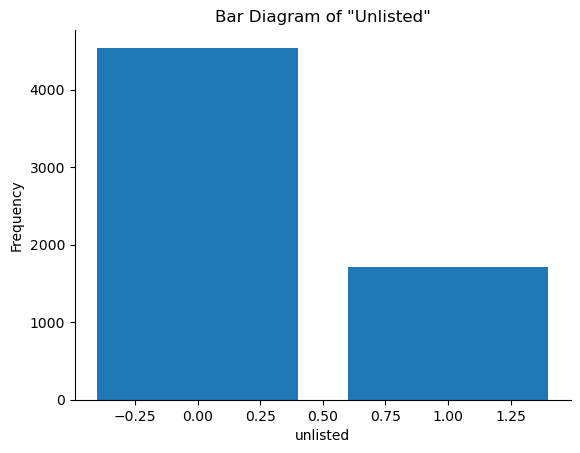

In [15]:
plt.bar(train_data['unlisted'].value_counts().index,data_train['unlisted'].value_counts().values)
plt.grid(False)  
plt.title('Bar Diagram of "Unlisted"')
plt.xlabel('unlisted')
plt.ylabel('Frequency')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [16]:
train_data['word_count_description']  = train_data['description'].apply(lambda x: len(str(x).split(" ")))
train_data['word_count_host_about']  = train_data['host_about'].apply(lambda x: len(str(x).split(" ")))
train_data['word_count_comments']  = train_data['comments'].apply(lambda x: len(str(x).split(" ")))
train_data[['description','host_about','word_count_description','word_count_host_about','word_count_comments']].head()

,description,host_about,word_count_description,word_count_host_about,word_count_comments
2835,"Cool loft, totally refurbished, located in a t...","I took a degree in Psychology, but I am not cu...",20,79,20496
4511,O Sea’Ya Family Surf Houses foi pensado por um...,"Apaixonados por mar, viagens e gastronomia, ma...",157,87,1776
4176,"This apartment is very well located, 2 minutes...","Olá,\nSou Brasileira a viver em Lisboa e estam...",181,14,1099
64,Casa da Fé is a beautiful home in magical Sint...,Hi ! I am Ida. I have been living in beautifu...,170,90,2056
1081,Enjoy your stay in our flat in Campo de Ouriqu...,"I'm Rita, 40 years old, born and raised in Lis...",167,29,7023


In [17]:
val_data['word_count_description']  = val_data['description'].apply(lambda x: len(str(x).split(" ")))
val_data['word_count_host_about']  = val_data['host_about'].apply(lambda x: len(str(x).split(" ")))
val_data['word_count_comments']  = train_data['comments'].apply(lambda x: len(str(x).split(" ")))
val_data[['description','host_about','word_count_description','word_count_host_about','word_count_comments']].head()

,description,host_about,word_count_description,word_count_host_about,word_count_comments
2295,This unique apartment combines quietness and r...,"Hello, I’m Antonio and I want to welcome you i...",156,12,NaN
123,Bright apartment with stunning river view to b...,Hi! I'm Miguel._x000D_\nI'm in love with Lisbo...,161,61,NaN
4240,"IMPORTANT: In response to COVID-19, this prope...","Hi, we are Homing - a company that develops it...",157,95,NaN
3946,Welcome to your Alfama apartment! <br />Stay h...,I am a guy who loves living in Lisbon and I ju...,168,52,NaN
4415,"Situada entre os vales da Serra de Montejunto,...",A Pro Touristic é uma empresa com mais de 15 a...,148,34,NaN


In [18]:
train_data['host_about'].isna().sum()

0

In [19]:
train_data['description'].isna().sum()

0

## Descriptive statistics of word count

In [20]:
train_data.word_count_host_about.describe()

count    4373.000000
mean       74.006174
std        81.402284
min         1.000000
25%        26.000000
50%        55.000000
75%       102.000000
max      1387.000000
Name: word_count_host_about, dtype: float64

In [21]:
train_data.word_count_description.describe()

count    4373.000000
mean      132.578779
std        48.207053
min         3.000000
25%        99.000000
50%       157.000000
75%       166.000000
max       210.000000
Name: word_count_description, dtype: float64

In [22]:
train_data.word_count_comments.describe()

count     4373.000000
mean      2829.928424
std       4636.995242
min          1.000000
25%          2.000000
50%        802.000000
75%       3627.000000
max      46976.000000
Name: word_count_comments, dtype: float64

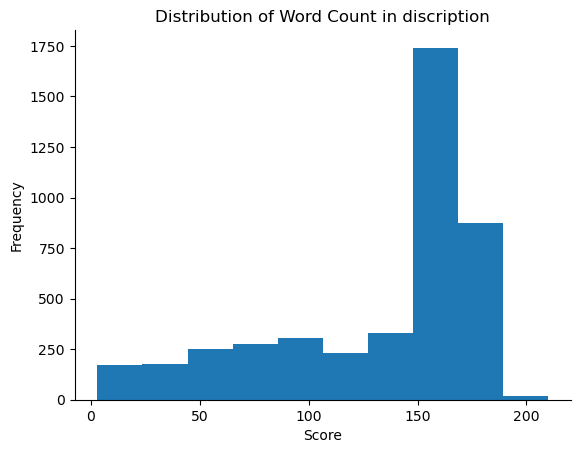

In [23]:
train_data['word_count_description'].hist()
plt.grid(False)  
plt.title('Distribution of Word Count in discription')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

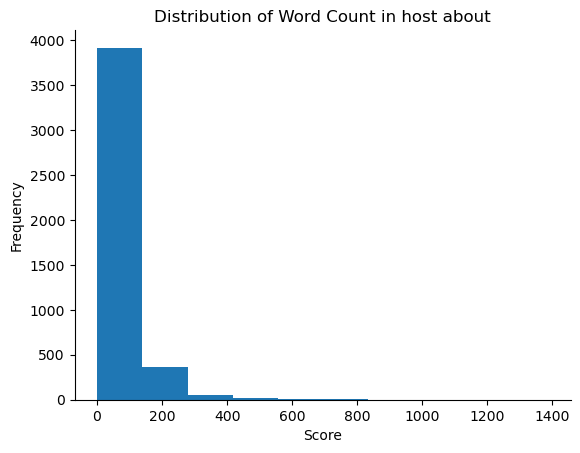

In [24]:
train_data['word_count_host_about'].hist()
plt.grid(False)  
plt.title('Distribution of Word Count in host about')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

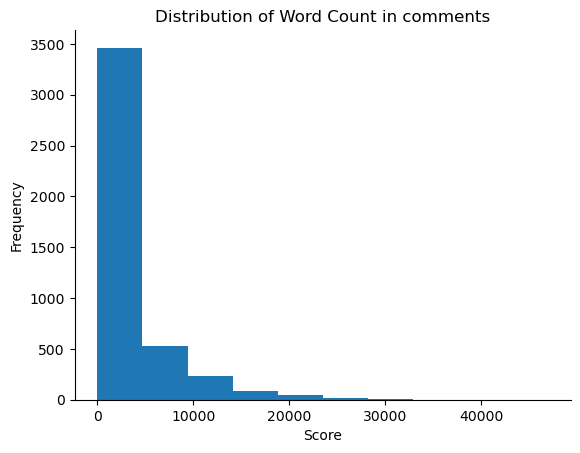

In [25]:
train_data['word_count_comments'].hist()
plt.grid(False)  
plt.title('Distribution of Word Count in comments')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [26]:
all_words_host_about = ' '.join(train_data['host_about']).split()
freq_host_about = pd.Series(all_words_host_about).value_counts()
freq_host_about.sort_values(ascending=False)[0:30]

and        11438
to          9363
the         7667
a           7421
in          6836
of          4611
I           4462
you         4374
de          3024
We          2937
e           2808
_x000D_     2763
for         2740
our         2718
with        2690
is          2462
we          2420
are         2017
have        1969
my          1917
love        1640
that        1626
your        1589
Lisbon      1437
as          1364
from        1353
all         1207
que         1153
be          1116
or          1069
Name: count, dtype: int64

In [27]:
all_words_description = ' '.join(train_data['description']).split()
freq_description = pd.Series(all_words_description).value_counts()
freq_description.sort_values(ascending=False)[0:30]

the             21966
and             19274
a               17706
/><br           12114
to              10603
of              10580
in               9840
with             9530
is               8473
de               4831
apartment        4750
for              4312
you              4196
<br              3825
space</b><br     3363
has              3313
/><b>The         3262
from             3116
e                3036
/>The            2939
The              2381
are              2213
room             2112
located          2077
2                1990
your             1982
can              1980
all              1971
on               1907
living           1905
Name: count, dtype: int64

In [28]:
all_words_comments = ' '.join(train_data['comments']).split()
freq_comments = pd.Series(all_words_description).value_counts()
freq_comments.sort_values(ascending=False)[0:30]

the             21966
and             19274
a               17706
/><br           12114
to              10603
of              10580
in               9840
with             9530
is               8473
de               4831
apartment        4750
for              4312
you              4196
<br              3825
space</b><br     3363
has              3313
/><b>The         3262
from             3116
e                3036
/>The            2939
The              2381
are              2213
room             2112
located          2077
2                1990
your             1982
can              1980
all              1971
on               1907
living           1905
Name: count, dtype: int64

In [29]:
freq_host_about.index[0:15]

Index(['and', 'to', 'the', 'a', 'in', 'of', 'I', 'you', 'de', 'We', 'e',
       '_x000D_', 'for', 'our', 'with'],
      dtype='object')

In [30]:
freq_description.index[0:15]

Index(['the', 'and', 'a', '/><br', 'to', 'of', 'in', 'with', 'is', 'de',
       'apartment', 'for', 'you', '<br', 'space</b><br'],
      dtype='object')

In [31]:
freq_comments.index[0:15]

Index(['the', 'and', 'a', '/><br', 'to', 'of', 'in', 'with', 'is', 'de',
       'apartment', 'for', 'you', '<br', 'space</b><br'],
      dtype='object')

In [32]:
common_words_host = set(freq_host_about.index[0:15])
common_words_description = set(freq_description.index[0:15])
common_words_comments = set(freq_comments.index[0:15])

In [33]:
most_common_words = common_words_host.intersection(common_words_description, common_words_comments)
most_common_words

{'a', 'and', 'de', 'for', 'in', 'of', 'the', 'to', 'with', 'you'}

#### N-Gram Analysis

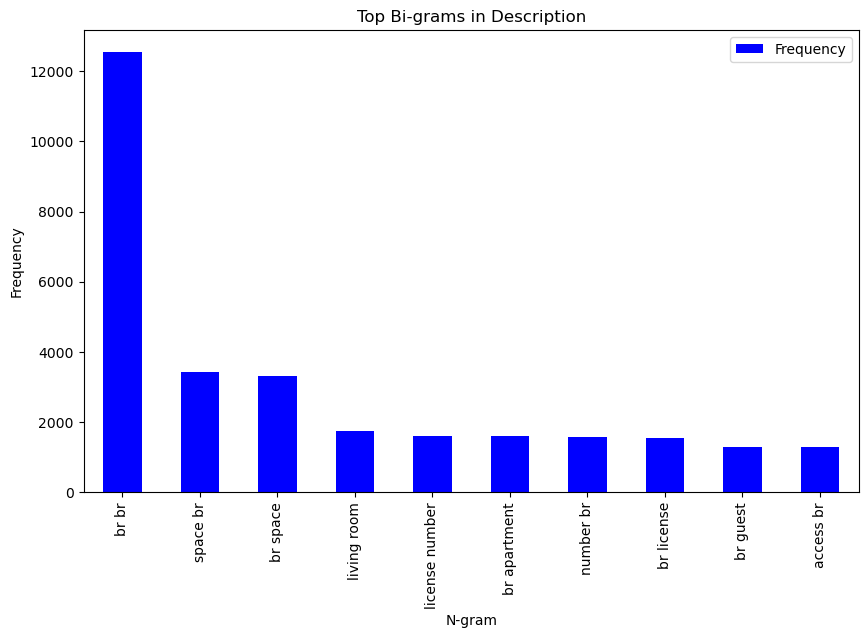

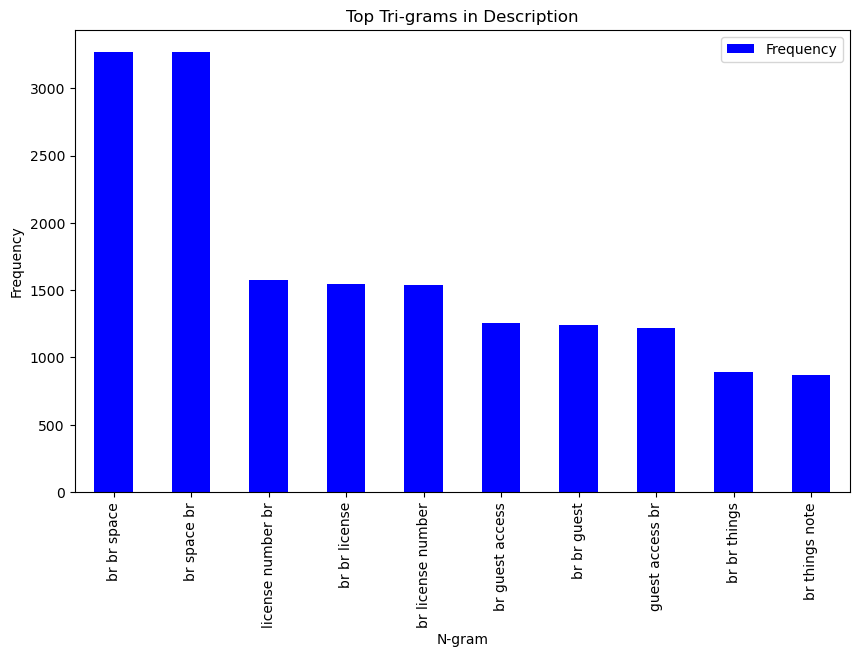

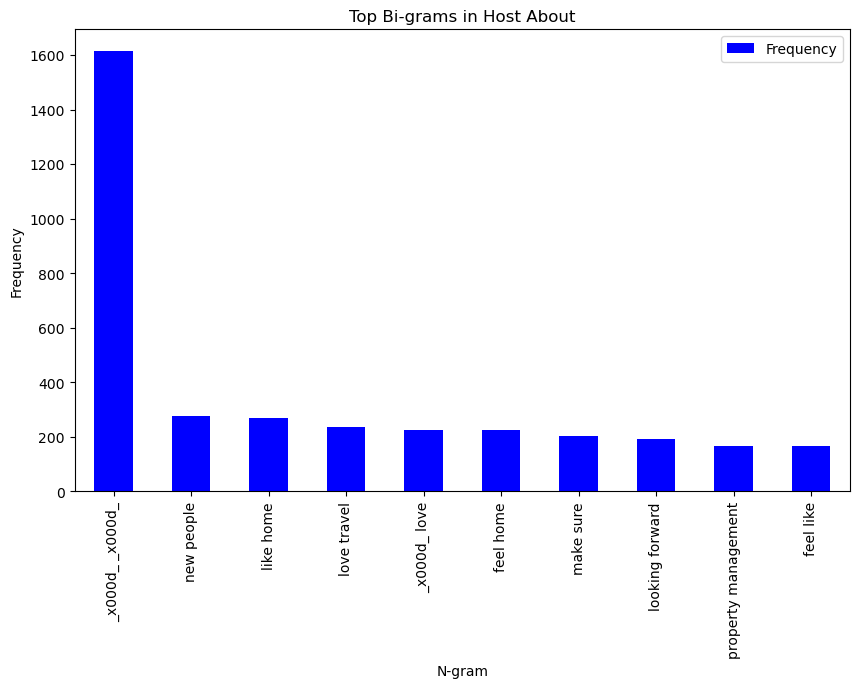

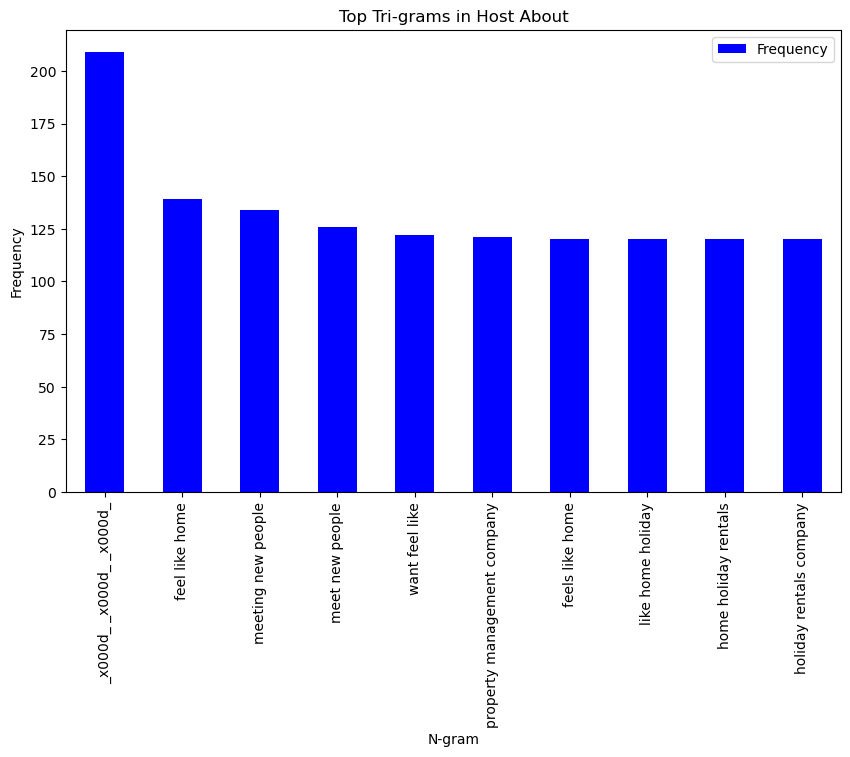

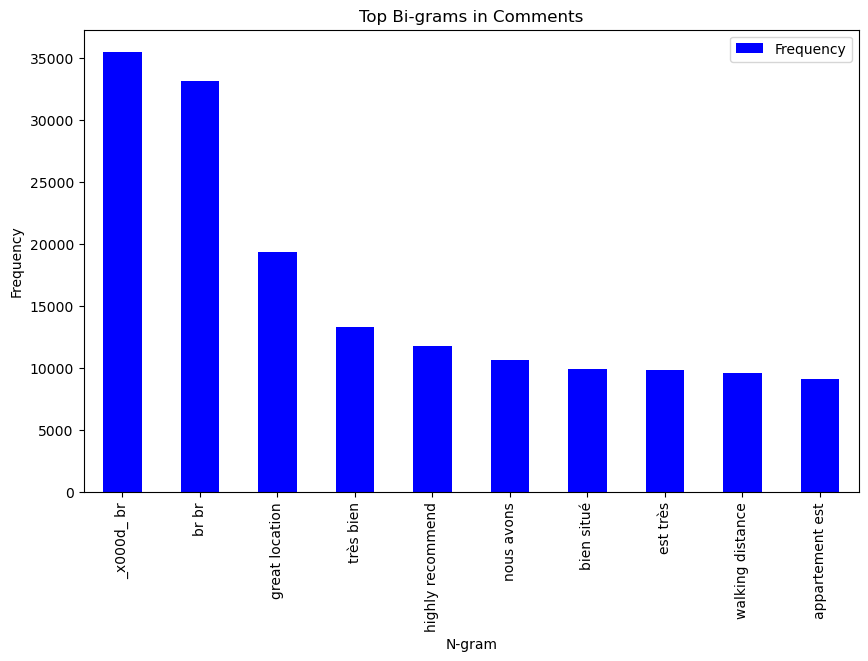

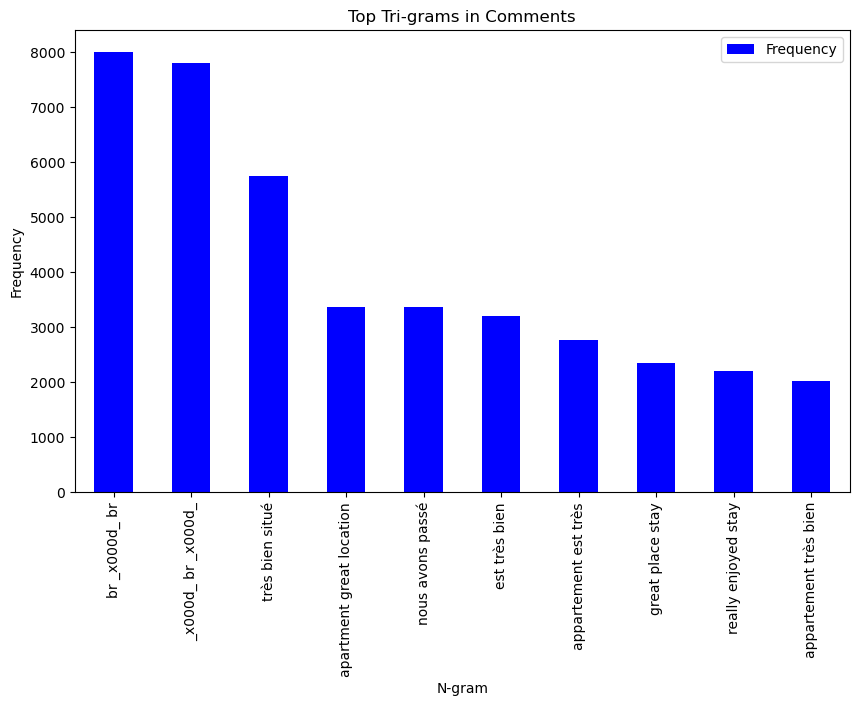

In [34]:
# Analyze bi-grams for 'description'
plot_top_ngrams(train_data['description'], ngrams=(2,2), top_n=10, title="Top Bi-grams in Description")

# Analyze tri-grams for 'description'
plot_top_ngrams(train_data['description'], ngrams=(3,3), top_n=10, title="Top Tri-grams in Description")

# Analyze bi-grams for 'host_about'
plot_top_ngrams(train_data['host_about'], ngrams=(2,2), top_n=10, title="Top Bi-grams in Host About")

# Analyze tri-grams for 'host_about'
plot_top_ngrams(train_data['host_about'], ngrams=(3,3), top_n=10, title="Top Tri-grams in Host About")

# Analyze bi-grams for 'comments'
plot_top_ngrams(train_data['comments'], ngrams=(2,2), top_n=10, title="Top Bi-grams in Comments")

# Analyze tri-grams for 'comments'
plot_top_ngrams(train_data['comments'], ngrams=(3,3), top_n=10, title="Top Tri-grams in Comments")

#shows a lot of HTML tags(br br/ number br/...)- we have to remove it 
#presence of words related with property descriptions and renting
#bi-grams and tri_grams can be used in the model tocreate features that might help in the prediction

#### Sentiment Analysis

In [35]:
sia = SentimentIntensityAnalyzer()

In [36]:
# Applying VADER to the DataFrame on the 'host_about' column
train_data['scores_host_about'] = train_data['host_about'].apply(lambda x: sia.polarity_scores(str(x)))
# Extracting the 'compound' score from the results
train_data['compound_host_about'] = train_data['scores_host_about'].apply(lambda x: x['compound'])

In [37]:
# Applying VADER to the DataFrame on the 'host_about' column
val_data['scores_host_about'] = val_data['host_about'].apply(lambda x: sia.polarity_scores(str(x)))
# Extracting the 'compound' score from the results
val_data['compound_host_about'] = val_data['scores_host_about'].apply(lambda x: x['compound'])

In [38]:
# Applying VADER to the DataFrame on the 'description' column
train_data['scores_description'] = train_data['description'].apply(lambda x: sia.polarity_scores(str(x)))
# Extracting the 'compound' score from the results
train_data['compound_description'] = train_data['scores_description'].apply(lambda x: x['compound'])

In [39]:
# Applying VADER to the DataFrame on the 'description' column
val_data['scores_description'] = val_data['description'].apply(lambda x: sia.polarity_scores(str(x)))
# Extracting the 'compound' score from the results
val_data['compound_description'] = val_data['scores_description'].apply(lambda x: x['compound'])

In [40]:
# Applying VADER to the DataFrame on the 'comments' column
train_data['scores_comments'] = train_data['comments'].apply(lambda x: sia.polarity_scores(str(x)))
# Extracting the 'compound' score from the results
train_data['compound_comments'] = train_data['scores_comments'].apply(lambda x: x['compound'])

In [41]:
# Applying VADER to the DataFrame on the 'comments' column
val_data['scores_comments'] = val_data['comments'].apply(lambda x: sia.polarity_scores(str(x)))
# Extracting the 'compound' score from the results
val_data['compound_comments'] = val_data['scores_comments'].apply(lambda x: x['compound'])

In [42]:
train_data["compound_description"].describe()

count    4373.000000
mean        0.686768
std         0.441346
min        -0.982300
25%         0.570700
50%         0.924500
75%         0.973200
max         0.997200
Name: compound_description, dtype: float64

In [43]:
train_data["compound_host_about"].describe()

count    4373.000000
mean        0.625337
std         0.449455
min        -0.948500
25%         0.000000
50%         0.893200
75%         0.975700
max         0.998900
Name: compound_host_about, dtype: float64

In [44]:
train_data["compound_comments"].describe()

count    4373.000000
mean        0.561699
std         0.610770
min        -0.998800
25%        -0.296000
50%         0.999300
75%         1.000000
max         1.000000
Name: compound_comments, dtype: float64

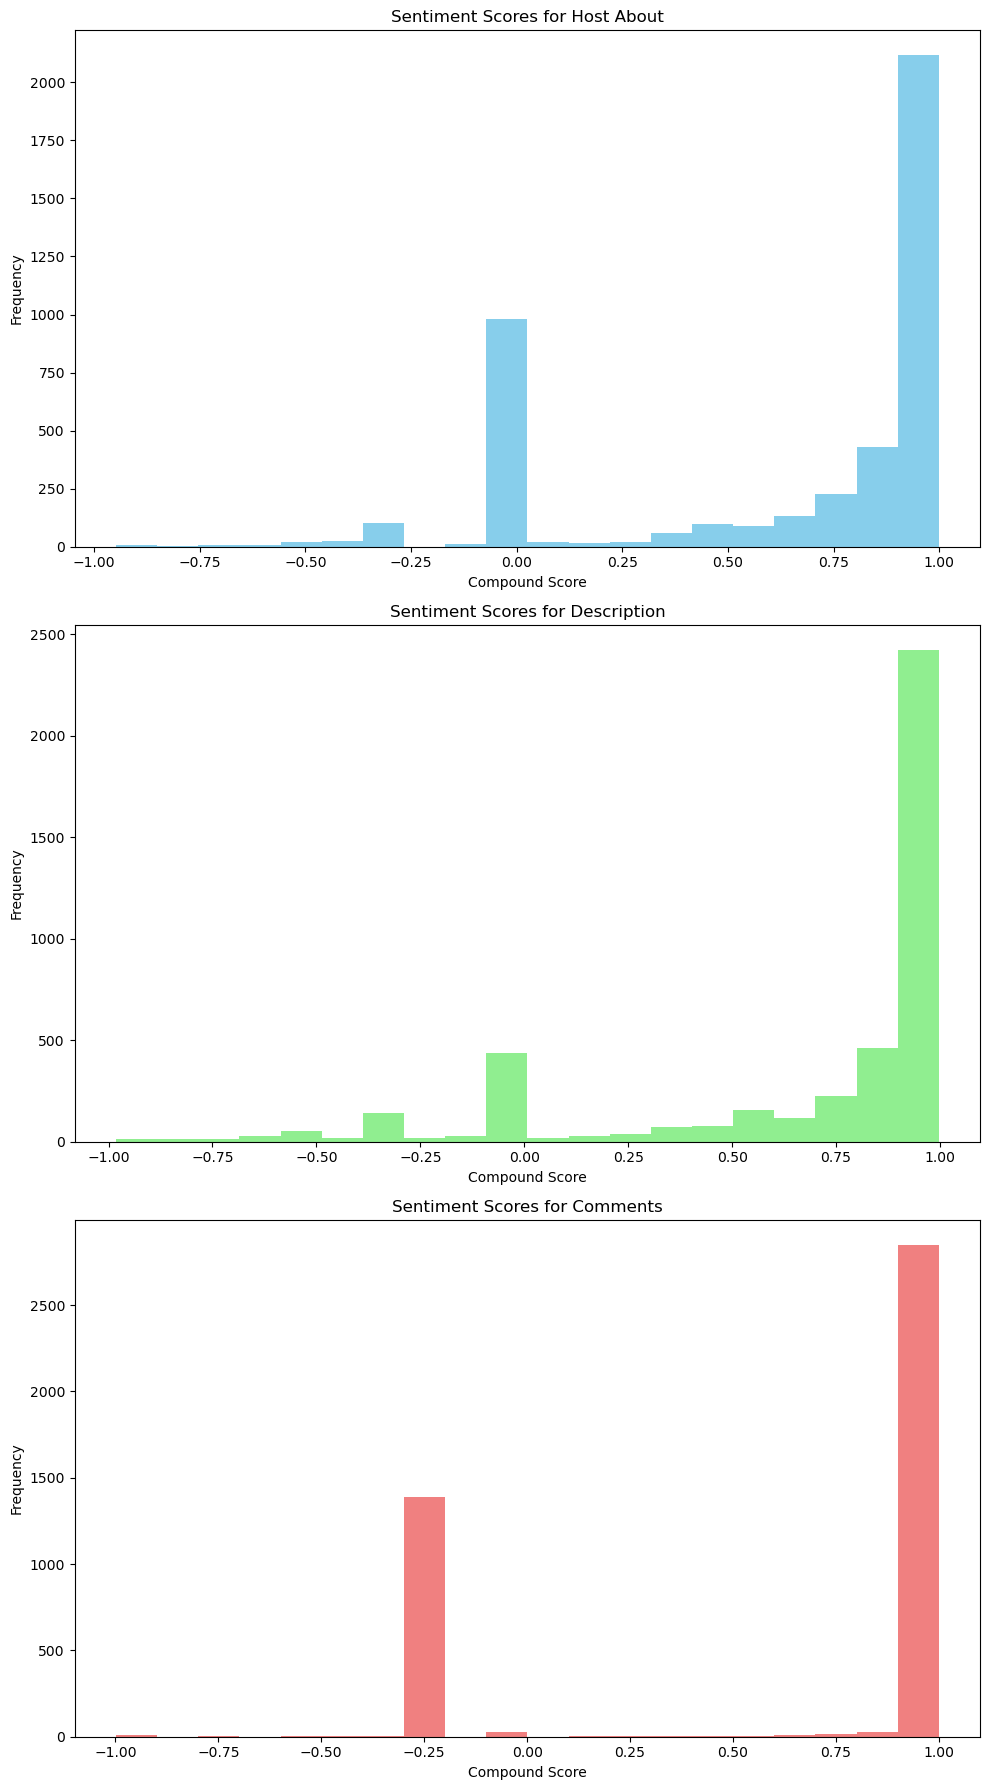

In [45]:
plt.figure(figsize=(10, 18))

# Plot for 'host_about'
plt.subplot(3, 1, 1)  # Changed to 3, 1, 1 for the first plot in a 3x1 grid
plt.hist(train_data['compound_host_about'], bins=20, color='skyblue')
plt.title('Sentiment Scores for Host About')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')

# Plot for 'description'
plt.subplot(3, 1, 2)  # Changed to 3, 1, 2 for the second plot in a 3x1 grid
plt.hist(train_data['compound_description'], bins=20, color='lightgreen')
plt.title('Sentiment Scores for Description')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')

# Plot for 'comments'
plt.subplot(3, 1, 3)  # Changed to 3, 1, 3 for the third plot in a 3x1 grid
plt.hist(train_data['compound_comments'], bins=20, color='lightcoral')  # Adjusted color for distinct visualization
plt.title('Sentiment Scores for Comments')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Named Entity Recognition

In [46]:
nlp = spacy.load("en_core_web_sm")

In [47]:
train_data['entities_host_about'] = train_data['host_about'].apply(extract_entities)


In [48]:
train_data['entities_description'] = train_data['description'].apply(extract_entities)

In [49]:
train_data['entities_comments'] = train_data['comments'].apply(extract_entities)

In [50]:
val_data['entities_host_about'] = val_data['host_about'].apply(extract_entities)

In [51]:
val_data['entities_description'] = val_data['description'].apply(extract_entities)

In [52]:
val_data['entities_comments'] = val_data['comments'].apply(extract_entities)

#### World Cloud

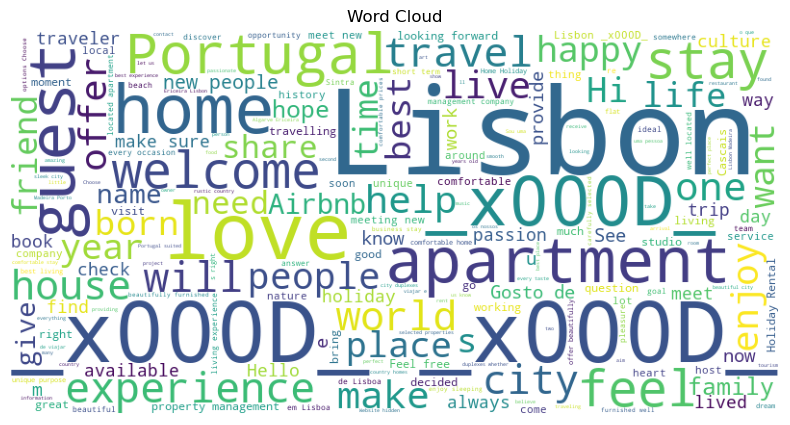

In [53]:
# Joining all the reviews into a single string
all_host_about = ' '.join(train_data['host_about'])
    
# Create WordCloud object
wordcloud_host_about = WordCloud(width=800, height=400, background_color="white").generate(all_host_about)

#Plotting the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_host_about)
plt.axis("off")
plt.title('Word Cloud')
plt.show()

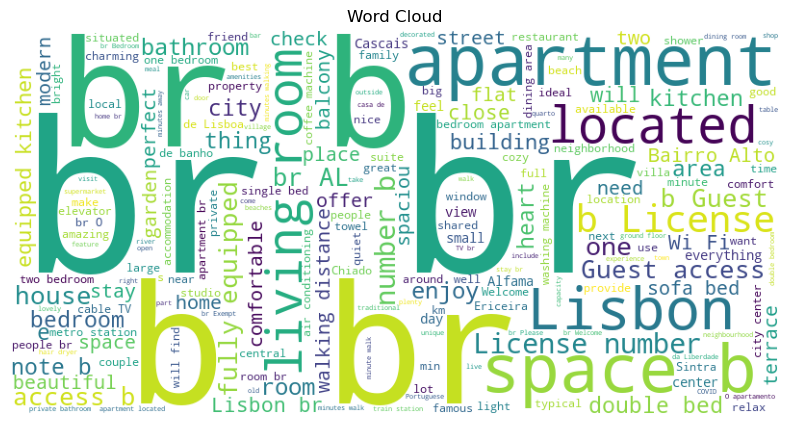

In [54]:
# Joining all the reviews into a single string
all_description = ' '.join(train_data['description'])
    
# Create WordCloud object
wordcloud_description = WordCloud(width=800, height=400, background_color="white").generate(all_description)

#Plotting the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_description)
plt.axis("off")
plt.title('Word Cloud')
plt.show()

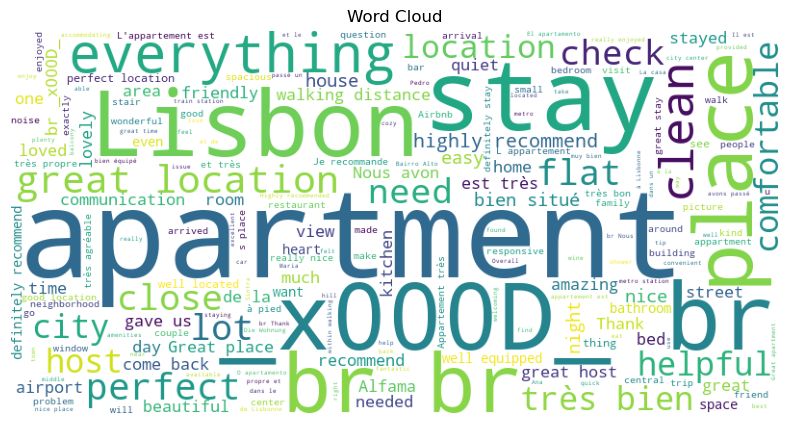

In [55]:
# Joining all the reviews into a single string
all_host_about = ' '.join(train_data['comments'])
    
# Create WordCloud object
wordcloud_comments = WordCloud(width=800, height=400, background_color="white").generate(all_host_about)

#Plotting the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_comments)
plt.axis("off")
plt.title('Word Cloud')
plt.show()

# Pre-Processing

#### Cleaning Text

In [56]:
train_data['description_cleaned'] = train_data['description'].apply(clean_text)
train_data['host_about_cleaned'] = train_data['host_about'].apply(clean_text)
train_data['comments_cleaned'] = train_data['comments'].apply(clean_text)
val_data['description_cleaned'] = val_data['description'].apply(clean_text)
val_data['host_about_cleaned'] = val_data['host_about'].apply(clean_text)
val_data['comments_cleaned'] = val_data['comments'].apply(clean_text)

C:\Users\Hp\AppData\Local\Temp\ipykernel_21060\4175748872.py:37: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
C:\Users\Hp\AppData\Local\Temp\ipykernel_21060\4175748872.py:37: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
C:\Users\Hp\AppData\Local\Temp\ipykernel_21060\4175748872.py:37: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
C:\Users\Hp\AppData\Local\Temp\ipykernel_21060\4175748872.py:37: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle i

#### Lowercase/Tokenization/Stop_Word/Lemmatize

In [57]:
train_data['preprocessed_description'] = train_data['description_cleaned'].apply(preprocess_text)
train_data['preprocessed_host_about'] = train_data['host_about_cleaned'].apply(preprocess_text)
train_data['preprocessed_comments'] = train_data['comments_cleaned'].apply(preprocess_text)


val_data['preprocessed_description'] = val_data['description_cleaned'].apply(preprocess_text)
val_data['preprocessed_host_about'] = val_data['host_about_cleaned'].apply(preprocess_text)
val_data['preprocessed_comments'] = val_data['comments_cleaned'].apply(preprocess_text)


In [58]:
train_data

,index,description,host_about,unlisted,comments,word_count_description,word_count_host_about,word_count_comments,scores_host_about,compound_host_about,...,compound_comments,entities_host_about,entities_description,entities_comments,description_cleaned,host_about_cleaned,comments_cleaned,preprocessed_description,preprocessed_host_about,preprocessed_comments
2835,2836,"Cool loft, totally refurbished, located in a t...","I took a degree in Psychology, but I am not cu...",0,The place was beautiful and recently renovated...,20,79,20496,"{'neg': 0.0, 'neu': 0.567, 'pos': 0.433, 'comp...",0.9946,...,1.0000,"[(three, CARDINAL), (x000D, PERSON), (x000D, P...","[(Lisbon, GPE), (License, ORG)]","[(Ines, ORG), (casa, ORG), (muito confortave, ...",Cool loft totally refurbished located in a typ...,I took a degree in Psychology but I am not cur...,The place was beautiful and recently renovated...,"[cool, loft, totally, refurbish, locate, typic...","[take, degree, psychology, curently, work, are...","[place, beautiful, recently, renovate, new, ap..."
4511,4512,O Sea’Ya Family Surf Houses foi pensado por um...,"Apaixonados por mar, viagens e gastronomia, ma...",0,Maria and Antonio are great hosts. First and f...,157,87,1776,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,...,1.0000,"[(mas acima de tudo, PERSON), (Cascais, GPE), ...","[(Family Surf Houses, PERSON), (conceito, PERS...","[(Maria, PERSON), (Antonio, PERSON), (First, O...",O SeaYa Family Surf Houses foi pensado por uma...,Apaixonados por mar viagens e gastronomia mas ...,Maria and Antonio are great hosts First and fo...,"[seaya, family, surf, houses, pensar, família,...","[apaixonar, mar, viagem, gastronomia, acima, c...","[maria, antonio, great, host, foremost, incred..."
4176,4177,"This apartment is very well located, 2 minutes...","Olá,\nSou Brasileira a viver em Lisboa e estam...",0,Un lugar cómodo para pasar unos días. No había...,181,14,1099,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,...,0.9997,"[(Sou Brasileira, PERSON), (Lisboa e estamos a...","[(2 minutes, TIME), (Marquês de Pombal, PERSON...","[(Un, ORG), (que se, PERSON), (estaba bien, PE...",This apartment is very well located 2 minutes ...,OláSou Brasileira a viver em Lisboa e estamos ...,Un lugar cómodo para pasar unos días No había ...,"[apartment, locate, 2, minute, walk, marquês, ...","[olásar, brasileira, viver, Lisboa, estar, rec...","[un, lugar, cómodo, para, pasar, unos, día, ha..."
64,65,Casa da Fé is a beautiful home in magical Sint...,Hi ! I am Ida. I have been living in beautifu...,0,Lovely place! Perfect location. Very friendly ...,170,90,2056,"{'neg': 0.0, 'neu': 0.703, 'pos': 0.297, 'comp...",0.9822,...,1.0000,"[(Ida, PERSON), (Sintra, NORP), (a few years, ...","[(Casa da Fé, PERSON), (São Pedro, PERSON), (S...","[(dueña muy, PERSON), (Haben, ORG), (Bemerkens...",Casa da Fé is a beautiful home in magical Sint...,Hi I am Ida I have been living in beautiful ...,Lovely place Perfect location Very friendly ho...,"[casa, da, fé, beautiful, home, magical, sintr...","[hi, , ida, , live, beautiful, sintra, year,...","[lovely, place, perfect, location, friendly, h..."
1081,1082,Enjoy your stay in our flat in Campo de Ouriqu...,"I'm Rita, 40 years old, born and raised in Lis...",0,"Le logement est très agréable. Tout neuf, très...",167,29,7023,"{'neg': 0.0, 'neu': 0.726, 'pos': 0.274, 'comp...",0.8802,...,1.0000,"[(40 years old, DATE), (Lisbon, GPE), (x000D, ...","[(Campo de Ourique, GPE), (2, CARDINAL), (3, C...","[(Un, ORG), (El apartamento, ORG), (Rita, PERS...",Enjoy your stay in our flat in Campo de Ouriqu...,Im Rita 40 years old born and raised in Lisbon...,Le logement est très agréable Tout neuf très b...,"[enjoy, stay, flat, campo, de, ourique, locati...","[m, rita, 40, year, old, bear, raise, lisbon, ...","[le, logement, est, très, agréable, tout, neuf..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5321,5322,It’s in the light that bat

In [59]:
val_data

,index,description,host_about,unlisted,comments,word_count_description,word_count_host_about,word_count_comments,scores_host_about,compound_host_about,...,compound_comments,entities_host_about,entities_description,entities_comments,description_cleaned,host_about_cleaned,comments_cleaned,preprocessed_description,preprocessed_host_about,preprocessed_comments
2295,2296,This unique apartment combines quietness and r...,"Hello, I’m Antonio and I want to welcome you i...",0,Always a pleasure to stay with Antonio! He's a...,156,12,NaN,"{'neg': 0.0, 'neu': 0.65, 'pos': 0.35, 'compou...",0.5106,...,1.0000,"[(Antonio, PERSON), (Lisbon, GPE)]","[(Just a few minutes, TIME), (Lisbon, GPE), (4...","[(Antonio, PERSON), (Lisbon, GPE), (Antonio, P...",This unique apartment combines quietness and r...,Hello Im Antonio and I want to welcome you in ...,Always a pleasure to stay with Antonio Hes a g...,"[unique, apartment, combine, quietness, relax,...","[hello, m, antonio, want, welcome, lisbon]","[pleasure, stay, antonio, s, great, host, cont..."
123,124,Bright apartment with stunning river view to b...,Hi! I'm Miguel._x000D_\nI'm in love with Lisbo...,0,Miguel and Sofia's apartment is great and they...,161,61,NaN,"{'neg': 0.0, 'neu': 0.688, 'pos': 0.312, 'comp...",0.9786,...,0.9997,"[(Miguel._x000D, ORG), (Lisbon, GPE), (home._x...","[(Tagus.<br, PRODUCT), (3rd, ORDINAL), (80, CA...","[(Miguel, PERSON), (three, CARDINAL), (La Boul...",Bright apartment with stunning river view to b...,Hi Im MiguelIm in love with Lisbon city where ...,Miguel and Sofias apartment is great and they ...,"[bright, apartment, stunning, river, view, enj...","[hi, m, miguelim, love, lisbon, city, bear, li...","[miguel, sofias, apartment, great, helpful, lo..."
4240,4241,"IMPORTANT: In response to COVID-19, this prope...","Hi, we are Homing - a company that develops it...",0,No reviews,157,95,NaN,"{'neg': 0.0, 'neu': 0.848, 'pos': 0.152, 'comp...",0.9413,...,-0.2960,"[(Homing, PERSON), (Lisbon, GPE), (Lisbon, GPE...","[(COVID-19, ORG), (Campo de Ourique, ORG), (Am...",[],IMPORTANT In response to COVID19 this property...,Hi we are Homing a company that develops its ...,No reviews,"[important, response, covid19, property, exten...","[hi, home, , company, develop, activity, tour...",[review]
3946,3947,Welcome to your Alfama apartment! <br />Stay h...,I am a guy who loves living in Lisbon and I ju...,0,Super appartement cosy dans le quartier le plu...,168,52,NaN,"{'neg': 0.0, 'neu': 0.615, 'pos': 0.385, 'comp...",0.9768,...,0.9994,"[(Lisbon, GPE), (Lisbon, GPE), (Lisbonner, PER...","[(Alfama, PERSON), (Alfama, ORG), (Portuguese,...","[(dans, NORP), (de la ville, ORG), (Accueil qu...",Welcome to your Alfama apartment Stay here an...,I am a guy who loves living in Lisbon and I ju...,Super appartement cosy dans le quartier le plu...,"[welcome, alfama, apartment, , stay, live, in...","[guy, love, live, lisbon, wish, share, guest, ...","[super, appartement, cosy, dan, le, quarti, le..."
4415,4416,"Situada entre os vales da Serra de Montejunto,...",A Pro Touristic é uma empresa com mais de 15 a...,1,No reviews,148,34,NaN,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,...,-0.2960,"[(Pro Touristic, NORP), (mais de, PERSON), (15...","[(Situada, ORG), (da Serra de Montejunto, ORG)...",[],Situada entre os vales da Serra de Montejunto ...,A Pro Touristic é uma empresa com mais de 15 a...,No reviews,"[situar, vale, serra, Montejunto, Montejunto, ...","[pro, Touristic, empresa, 15, ano, experiência...",[review]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926,927,"Apartamento muito limpo, bem silencioso, reg...","Sou uma pessoa muito sociável, amo viajar.",0,No reviews,57,7,NaN,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,...,-0.2960,"[(muito sociável, PERSON), (amo viajar, GPE)]","[(Apartamento, ORG), (do metro, PERSON), (comb...",[],Apartamento muito limpo bem silencioso regiã...,Sou uma pessoa muito sociável amo viaja

In [60]:
#should we replace the city names with "location" because they are regular expressions???
# we can also apply POS Filter, be aware for the different languages and the need to use the fuction to detect the different languages
# We can also for the N-gram Creation
#Another technique we can apply is Text Expansion to replace contractions such as “isn’t” with “is not”, can help in standardizing text input, useful for informal text
#Other techniques are speeling correction/Advanced Sentence Segmentation/Dependency Parsing/Coreference Resolution/Text Augmentation/Semantic Role Labeling...